In [222]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import os

In [223]:
url = "https://www.cenace.gob.mx/graficademanda.aspx"
clave_region = ["ccbc", "ccbcsur", "cccentral", "ccnoreste", "ccnoroeste", 
                "ccnorte", "ccoccidental", "ccoriental", "ccpeninsular", "sinacional"]
datos = []
fecha = datetime.datetime.now().strftime("%d-%m-%Y %H_%M_%S")

In [226]:
def obtener_contenido(url):
    pagina_web = requests.get(url)
    return pagina_web.content

In [227]:
def genera_soup(contenido_web):
    return BeautifulSoup(contenido_web, "html.parser")

In [228]:
def extraccion_pagina(soup):
          
    for clave in clave_region:
        
      titulo_region = soup.find("li", class_ = clave)
      region = titulo_region.select_one(".titlex").text

      p_tags = soup.select("li." + clave + " p") # Selecciono las 3 etiquetas p
      for p_tag in p_tags:
            if "Demanda Neta:" in p_tag.text:
                 demanda_neta = float(p_tag.select_one(".bold").text.replace(",","")[:-3]) 
            elif "Generación Neta:" in p_tag.text:
                 generacion_neta = float(p_tag.select_one(".bold").text.replace(",","")[:-3])              
               
      datos.append({
              "Fecha" : fecha,
              "Región": region,
              "Generación Neta MW" : generacion_neta,
              "Demanda Neta MW" : demanda_neta,
              "Diferencia MW" : generacion_neta - demanda_neta
              })
      
    return pd.DataFrame(datos)
    

In [229]:
def actualizar_datos(df):

    documentos = os.listdir("../csv_se")
    n_update = int(documentos[-1].split()[0])
    new_n_update = str(n_update + 1)
    ultimo = documentos[-1]
    fecha_actual = fecha

    df_base = pd.read_csv("../csv_se/" + ultimo)
    df_nuevo = pd.concat([df_base,df], ignore_index=True)

    columnas = ["Fecha", "Región", "Generación Neta MW", "Demanda Neta MW", "Diferencia MW"]
    df_nuevo = df_nuevo[columnas]
    df_nuevo.to_csv("../csv_se/" + new_n_update + " " + fecha_actual + ".csv")

In [230]:
def proceso_datos(url):
    contenido_web = obtener_contenido(url)
    soup = genera_soup(contenido_web)
    df = extraccion_pagina(soup)
    actualizar_datos(df)    

In [231]:
proceso_datos(url)

In [232]:
documentos = os.listdir("../csv_se")
ultimo = documentos[-1]
df = pd.read_csv("../csv_se/" + ultimo)
df = df[["Fecha", "Región", "Generación Neta MW", "Demanda Neta MW", "Diferencia MW"]]
df = pd.DataFrame(df)
df

,Fecha,Región,Generación Neta MW,Demanda Neta MW,Diferencia MW
0,02-08-2023 00_46_06,Baja California,2419.0,2445.0,-26.0
1,02-08-2023 00_46_06,Baja California Sur,593.0,582.0,11.0
2,02-08-2023 00_46_06,CENTRAL,3913.0,5876.0,-1963.0
3,02-08-2023 00_46_06,NORESTE,12425.0,9887.0,2538.0
4,02-08-2023 00_46_06,NOROESTE,4779.0,4748.0,31.0
5,02-08-2023 00_46_06,NORTE,4143.0,4408.0,-265.0
6,02-08-2023 00_46_06,OCCIDENTAL,6115.0,8805.0,-2690.0
7,02-08-2023 00_46_06,ORIENTAL,10042.0,6865.0,3177.0
8,02-08-2023 00_46_06,PENINSULAR,1343.0,2219.0,-876.0
9,02-08-2023 00_46_06,S.I. NACIONAL,42766.0,42816.0,-50.0


In [233]:
df_central = df[df["Región"] == "CENTRAL"]
df_central

,Fecha,Región,Generación Neta MW,Demanda Neta MW,Diferencia MW
2,02-08-2023 00_46_06,CENTRAL,3913.0,5876.0,-1963.0
12,02-08-2023 01_24_21,CENTRAL,4238.0,5945.0,-1707.0
22,02-08-2023 09_26_50,CENTRAL,3715.0,6954.0,-3239.0
32,02-08-2023 11_03_28,CENTRAL,3762.0,7150.0,-3388.0
42,02-08-2023 12_00_27,CENTRAL,3789.0,7516.0,-3727.0


In [234]:
df_central["Fecha"] = pd.to_datetime(df_central["Fecha"], format="%d-%m-%Y %H_%M_%S")
df_central["Hora"] = df_central["Fecha"].dt.strftime("%H")
df_central["Día"] = df_central["Fecha"].dt.strftime("%d-%m-%Y")
df_central

C:\Users\Admin\AppData\Local\Temp\ipykernel_9268\3604863440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_central["Fecha"] = pd.to_datetime(df_central["Fecha"], format="%d-%m-%Y %H_%M_%S")
C:\Users\Admin\AppData\Local\Temp\ipykernel_9268\3604863440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_central["Hora"] = df_central["Fecha"].dt.strftime("%H")
C:\Users\Admin\AppData\Local\Temp\ipykernel_9268\3604863440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

,Fecha,Región,Generación Neta MW,Demanda Neta MW,Diferencia MW,Hora,Día
2,2023-08-02 00:46:06,CENTRAL,3913.0,5876.0,-1963.0,00,02-08-2023
12,2023-08-02 01:24:21,CENTRAL,4238.0,5945.0,-1707.0,01,02-08-2023
22,2023-08-02 09:26:50,CENTRAL,3715.0,6954.0,-3239.0,09,02-08-2023
32,2023-08-02 11:03:28,CENTRAL,3762.0,7150.0,-3388.0,11,02-08-2023
42,2023-08-02 12:00:27,CENTRAL,3789.0,7516.0,-3727.0,12,02-08-2023


In [235]:
import matplotlib.pyplot as plt
import numpy as np

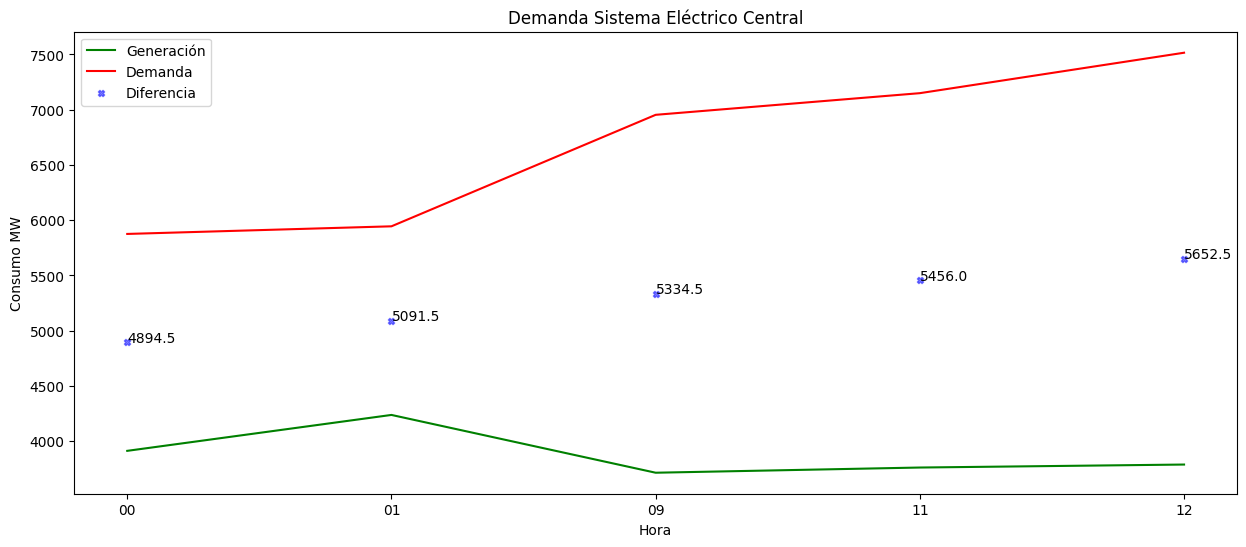

In [236]:
puntos_medios = (df_central["Generación Neta MW"] + df_central["Demanda Neta MW"])/2

plt.figure(figsize=(15, 6)) 
plt.plot(df_central["Hora"], df_central["Generación Neta MW"], label = "Generación", color = "green")
plt.plot(df_central["Hora"], df_central["Demanda Neta MW"], label = "Demanda", color = "red")
plt.scatter(df_central["Hora"], puntos_medios , label = "Diferencia", marker = "X", s = 20, alpha = 0.5, color = "blue")
plt.title("Demanda Sistema Eléctrico Central")

for i, valor in enumerate(puntos_medios):
    plt.text(df_central["Hora"].iloc[i], valor, f"{valor}")

plt.xlabel("Hora")
plt.ylabel("Consumo MW")

plt.legend()
plt.show()